# Importing the Modules

- Let us start by importing the necessary modules.

In [ ]:
import tensorflow as tf
from tensorflow import keras

Let's start by loading and preparing the California housing dataset.

We would:
 
 - first load the data

 - then split it into a training set, a validation set, and a test set

 - finally, we scale it. 

Note that this dataset contains only numerical features and there are no missing values.

**Note:**

- For a feature scaler line `StandardScler`, `fit` computes the mean and std(standard deviation) to be used for later scaling (just a computation) based on the given data, nothing is given to you. `transform` uses a previously computed mean and std to autoscale the data (subtract mean from all values and then divide it by std). `fit_transform` does both at the same time.

- So, we would be applying the `scaler.fit_transform` on the train data, and just apply `scaler.transform` on the validation and test data.

In [ ]:
# Use fetch_california_housing() function to load the data. 
# This dataset contains only numerical features (there is no ocean_proximity feature)
# And there is no missing value. 
# After loading the data, we split it into a training set, a validation set, and a test set
# And we scale all the features


from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# fetch the data
housing = fetch_california_housing()

# split it into a training set, a validation set, and a test set
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

# Scale all the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [ ]:
print(X_test_scaled.min())
X_test.min()

-2.33173089548745


-124.25

# Defining a Custom Loss Function - Huber Loss

Let's implement huber loss. Huber loss is less sensitive to outliers in data than mean squared error. 

Below is the formula of huber loss.

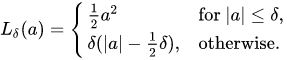


  [1]: https://cxl-web-prod-uploads.s3.amazonaws.com/public/pagedown-uploads/03cb0080a7a3c2d5fbbfabdfab8f4e538131c5cb.png

**Note:**

- Huber loss is defined as:
 
 - *error <sup>2</sup>/2*, if *error < delta*  (ie, if it is a small error)

 - *delta \* ( |error| - delta/2)*, otherwise  ( *|error|* means the absolute value *error*)

  In this exercise, we consider *delta=1*.

 Thus, the  `huber_fn`  is defined as:
  
  - *error <sup>2</sup>/2*, if *error < 1* (ie, if it is a small error).

 - *|error| - 0.5*, otherwise

- `tf.abs(x)` returns the positive value(absolute value) of `x`.

- `tf.square(x)` returns the squared value of `x`.

- `tf.where(bool_array, x, y)` returns the elements where condition is True in `bool_array` (multiplexing `x` and `y`).

  In simpler terms, `tf.where` will choose an output shape from the shapes of condition, `x`, and `y` that all three shapes are broadcastable to.

 The condition tensor acts as a mask that chooses whether the corresponding element/row in the output should be taken from x (if the element in the condition is `True`) or from `y` (if it is `False`).
 
 For example, upon executing the following,

 `tf.where([True, False, False, True], [1,2,3,4], [100,200,300,400])`

 the output would be : `<tf.Tensor: shape=(4,), dtype=int32, numpy=array([  1, 200, 300,   4], dtype=int32)>`

In [ ]:
# Define a custom loss function
# Define Huber loss function

def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss  = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

In [ ]:
huber_fn(1.5, 2.5)

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [ ]:
tf.where([True, False, False, True], [1,2,3,4], [100,200,300,400])

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([  1, 200, 300,   4], dtype=int32)>

# Building the Network

We shall now build the classification network, with a hidden layer(with 30 neurons and `selu` activation function) and an output layer( with 1 neuron since we have to predict only one value).

We shall also specify the loss function we have defined - the `huber_fn` and the optimizer to use, while compiling.

**Note:**

- `kernel_initializer` defines the way to set the initial random weights of Keras layers.

In [ ]:
# Build the network.
# Output layer just contains 1 neuron since we have to predict only one value

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=X_train.shape[1:]),
    keras.layers.Dense(1),
])

In [ ]:
# Specify the loss function and the optimizer to use.
# Here we are using custom loss function
# Measure MAE during training and evaluation

model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])

In [ ]:
str(type(model))=="<class 'tensorflow.python.keras.engine.sequential.Sequential'>"

True

# Training the Model

- It's time for training.


In [ ]:
model.fit(X_train_scaled, y_train, epochs=15,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/15
363/363 [==============================] - 1s 1ms/step - loss: 0.6084 - mae: 0.9652 - val_loss: 0.3084 - val_mae: 0.6046
Epoch 2/15
363/363 [==============================] - 0s 1ms/step - loss: 0.2187 - mae: 0.5153 - val_loss: 0.2605 - val_mae: 0.5472
Epoch 3/15
363/363 [==============================] - 0s 1ms/step - loss: 0.2053 - mae: 0.4964 - val_loss: 0.2199 - val_mae: 0.5018
Epoch 4/15
363/363 [==============================] - 0s 1ms/step - loss: 0.1984 - mae: 0.4877 - val_loss: 0.1834 - val_mae: 0.4637
Epoch 5/15
363/363 [==============================] - 0s 1ms/step - loss: 0.1936 - mae: 0.4816 - val_loss: 0.2008 - val_mae: 0.4816
Epoch 6/15
363/363 [==============================] - 0s 1ms/step - loss: 0.1920 - mae: 0.4785 - val_loss: 0.1901 - val_mae: 0.4731
Epoch 7/15
363/363 [==============================] - 0s 1ms/step - loss: 0.1894 - mae: 0.4745 - val_loss: 0.1874 - val_mae: 0.4695
Epoch 8/15
363/363 [==============================] - 0s 1ms/step - loss: 0.

# Evaluating the Model Performance

Let us test the model performance by looking at the mae and loss values of the model on test data.

In [ ]:
model.evaluate(X_test_scaled, y_test)

162/162 [==============================] - 0s 742us/step - loss: 0.1776 - mae: 0.4575


[0.1775917261838913, 0.4575499892234802]

Observe the values of loss and mae. These values are nearly the same as those of the train and validation datasets. Also, the values are low. Hence our model hasn't been overfitted and is giving a decent performance.